# Figures

## Load packages.

In [1]:
require(data.table)
require(deSolve)
require(magrittr)
require(SobolSequence)

require(ggplot2)
#require(GGally)

Loading required package: data.table
Loading required package: deSolve
Loading required package: magrittr
Loading required package: SobolSequence
Loading required package: ggplot2


## Toy model.

### Function to generate simulations.

In [2]:
# Create a multivariate function with specified properties:
#   tmax: maximum time
#   multiplicities: number of correlations each parameter has
#   degrees: polynomial degree of each parameter
#   dimension: the dimension of the output
#   returns a multivariate function of the vector of parameters and time
makeGenerator <- function(multiplicities, degrees, dimension) {

    single <- function(degree) {
      x0 <- runif(1)
      z0 <- runif(1)
      print(paste("x0 = ", x0, " z0 = ", z0, sep = ""))
      function(x) {
          if (x < x0)
              0
          else
              z0 * (x - x0)^degree
      }
    }
  
    locations <- lapply(multiplicities, function(m) sample(1:dimension, m))
    functions <- lapply(degrees, single)
    print(paste("locations = ", locations, sep = ""))

    start <- runif(dimension, -0.25, 0.75)
    coefs <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)    
    shift <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)
    print(paste("start = ", start, sep = ""))
    print(paste("coefs = ", coefs, sep = ""))
    print(paste("shift = ", shift, sep = ""))
                        
    function(x, ts) {
        z <- rep(0, dimension)
        for (i in 1:length(locations))
            for (j in locations[[i]])
                z[j] <- z[j] + functions[[i]](x[i])
        ode(start, ts, function(t, y, params) {list((coefs %*% y) * z * (1 - ((shift %*% y) * z)))})
    }
    
}


### Reproducible random numbers.

In [3]:
RNGkind("Mersenne-Twister", "Inversion", "Rejection")

In [4]:
set.seed(46)

### Create a simulation function.

In [5]:
f <- makeGenerator(c(2, 2, 3), c(0, 1, 2), 3)

[1] "x0 = 0.593385165324435 z0 = 0.878765949280933"
[1] "x0 = 0.948547213338315 z0 = 0.266811488429084"
[1] "x0 = 0.102978735696524 z0 = 0.666119117988274"
[1] "locations = 2:3" "locations = 1:2" "locations = 3:1"
[1] "start = -0.190031975274906" "start = 0.514496699674055" 
[3] "start = 0.409361242316663" 
[1] "coefs = 0.705375556601211"   "coefs = -0.115145863266662" 
[3] "coefs = 0.347464276012033"   "coefs = 0.292149275774136"  
[5] "coefs = 0.520560818491504"   "coefs = -0.057829137891531" 
[7] "coefs = 0.736122698988765"   "coefs = -0.0706934879999608"
[9] "coefs = -0.222858148626983" 
[1] "shift = 0.0293900212273002"  "shift = 0.104585286928341"  
[3] "shift = -0.125812432728708"  "shift = 0.166828206041828"  
[5] "shift = 0.170498313149437"   "shift = -0.0711941269692034"
[7] "shift = 0.578821994364262"   "shift = 0.274879416683689"  
[9] "shift = 0.737152222543955"  


### Sample evaluation.

In [6]:
ts <- seq(0, 10, 0.5)

In [7]:
f(c(0.1, 0.2, 0.3), ts)

time,1,2,3
0.0,-0.1900320,0.5144967,0.4093612
0.5,-0.1859459,0.5178616,0.4069727
1.0,-0.1818325,0.5212452,0.4046066
1.5,-0.1776913,0.5246476,0.4022630
2.0,-0.1735216,0.5280687,0.3999419
2.5,-0.1693230,0.5315086,0.3976434
3.0,-0.1650949,0.5349675,0.3953675
3.5,-0.1608367,0.5384453,0.3931142
4.0,-0.1565478,0.5419422,0.3908837
4.5,-0.1522278,0.5454581,0.3886761


### Functions for adapative sensitivity analysis.

#### Initialize the design.

In [8]:
ssa.initialize <- function(n, f, ts) {
    k <- 3
    design <- sobolSequence.points(2 * k, count = n)[, 1:(2*k)]
    colnames(design) <- c("xa1", "xa2", "xa3", "xb1", "xb2", "xb3")
    list(
        f  = f
    ,   ts = ts
    ,   n  = n
    ,   k  = 3
    ,   m  = 3
    ,   x  = data.table(j = 1:nrow(design), design)
    ,   y  = data.table(
            j    = integer()
        ,   i    = integer()
        ,   l    = integer()
        ,   ya   = numeric()
        ,   yb   = numeric()
        ,   yaib = numeric()
        )

    )
}

#### Update the evaluations.

In [9]:
ssa.evaluate <- function(ssa) {
    for (row in setdiff(ssa$x$j, unique(ssa$y$j))) {
        ya   <- ssa$f(as.numeric(ssa$x[row, .(xa1, xa2, xa3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        yb   <- ssa$f(as.numeric(ssa$x[row, .(xb1, xb2, xb3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        ya1b <- ssa$f(as.numeric(ssa$x[row, .(xb1, xa2, xa3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        ya2b <- ssa$f(as.numeric(ssa$x[row, .(xa1, xb2, xa3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        ya3b <- ssa$f(as.numeric(ssa$x[row, .(xa1, xa2, xb3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        ssa$y <- rbind(
            ssa$y,
            data.table(
                j    = row
            ,   i    = rep(1:ssa$k, each  = ssa$m)
            ,   l    = rep(1:ssa$m, times = ssa$k)
            ,   ya   = rep(ya     , times = ssa$m)
            ,   yb   = rep(yb     , times = ssa$m)
            ,   yaib = c(ya1b, ya2b, ya3b)
            )
        )
    }
    ssa
}

#### Compute local sensitivities.

In [10]:
ssa.sensitivity.local <- function(ssa, alpha = 2) {
    st <- merge(
        merge(rbind(
            ssa$x[, .(j, i = 1, xa = xa1, xb = xb1)]
        ,   ssa$x[, .(j, i = 2, xa = xa2, xb = xb2)]
        ,   ssa$x[, .(j, i = 3, xa = xa3, xb = xb3)]
        ), ssa$y)
    ,   ssa$y[i == 1, .(scale = sum(abs(ya - yb)^alpha)), by = .(l)][scale > 0]
    ,   by = "l"
    )[, .(
        j, i, l
    ,   xa, xb
    ,   s = abs(yb - yaib)^alpha / scale
    ,   t = abs(ya - yaib)^alpha / scale
    )][order(j, i, l)]
    melt(
        melt(
            st[, .(
                Observation = j
            ,   Input       = paste("x", i, sep="_")
            ,   Output      = paste("y", l, sep="_")
            ,   a           = xa
            ,   b           = xb
            ,   First       = s
            ,   Total       = t
            )]
        ,   id.vars = c("Observation", "Input", "Output", "First", "Total")
        ,   variable.name = "Block"
        ,   value.name = "x"
        )
    ,   id.vars = c("Observation", "Input", "Output", "Block", "x")
    ,   variable.name = "Sensitivity"
    ,   value.name = "Index"
    )
}

#### Compute global sensitivities.

In [11]:
ssa.sensitivity.global <- function(local) {
    dcast(
        local[Block == "a", .(Index = sum(Index)), by = .(Input, Output, Sensitivity)]
    ,   Input + Output ~ Sensitivity
    ,   value.var = "Index"
    )[, .(Input, Output, First = 1 - First, Total)]
}

#### Compute the sensitivity density.

In [12]:
ssa.sensitivity.density <- function(local, epsilon = 1e-4) {
    density <- local[
        Sensitivity == "Total" # & Index > 0
    ,   .(
            xmin   = min(x) - epsilon / 2
        ,   xmax   = max(x) + epsilon / 2
        ,   Index  = mean(Index)
        ,   Weight = 1
        )
    ,   by = .(Input, Output, Observation)
    ][, .(
        Input
    ,   Output
    ,   xmin
    ,   xmax
    ,   Index  = Index  / (xmax - xmin + epsilon)
    ,   Weight = Weight / (xmax - xmin + epsilon)
    )]
    rbind(
        density[, .(x = xmin, Index          , Weight           ), by = .(Input, Output)]
    ,   density[, .(x = xmax, Index = - Index, Weight = - Weight), by = .(Input, Output)]
    )[order(Input, Output, x)][, .(x, Index = cumsum(Index), Weight = cumsum(Weight)), by = .(Input, Output)]
}

#### Compute metric for sensitivity-based sampling.

In [13]:
ssa.metric <- function(density) {
    metric <- density[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, Output, x)
    ]
    merge(
        metric
    ,   metric[, .(Scale = sum(Density)), by = .(Input, Output)][Scale > 0]
    )[
        , .(Density = Density / Scale), by = .(Input, Output, x)
    ][
        , .(Density = mean(Density)), by = .(Input, x)
    ][
        order(Input, x)
    ][
        , .(x, Density, Cumulative = cumsum(Density)), by = Input
    ]
}

#### Expand the experiment based on a sensitivity metric.

In [14]:
ssa.expand <- function(ssa, metric, n, beta = 0.5) {
    design <- sobolSequence.points(2 * ssa$k, count = ssa$n + n)[ssa$n + 1:n, 1:(2*ssa$k)]
    f <- function(x_i, xsample) {
        mapply(
            function(x, y)
                if (runif(1) <= beta) y else x
        ,   xsample
        ,   approx(
                c(0, metric[Input == x_i, Cumulative], 1)
            ,   c(0, metric[Input == x_i, x         ], 1)
            ,   xsample
            ,   rule = 2
            ,   ties = "ordered"
            )$y
        )
    }
    ssa$x <- rbind(
        ssa$x
    ,   data.table(
            j = ssa$n + 1:n
        ,   xa1 = f("x_1", design[, 1])
        ,   xa2 = f("x_2", design[, 2])
        ,   xa3 = f("x_3", design[, 3])
        ,   xb1 = f("x_1", design[, 4])
        ,   xb2 = f("x_2", design[, 5])
        ,   xb3 = f("x_3", design[, 6])
        )
    )
    ssa$n <- ssa$n + n
    ssa
}

### Single large batch.

#### Initialize.

In [15]:
w <- ssa.initialize(1000, f, (0:20) / 2)

In [16]:
w <- ssa.evaluate(w)

#### Global sensitivities.

In [17]:
w.local <- ssa.sensitivity.local(w, alpha = 2)
ssa.sensitivity.global(w.local)

Input,Output,First,Total
<chr>,<chr>,<dbl>,<dbl>
x_1,y_1,0.0073512564,1.681385e-02
x_1,y_2,0.6206264739,9.369532e-01
x_1,y_3,0.1338078530,4.060176e-01
x_2,y_1,-0.0002645010,9.199686e-05
x_2,y_2,0.0001284894,5.162211e-05
x_2,y_3,0.0001398304,1.188286e-04
x_3,y_1,0.9828685869,9.925200e-01
x_3,y_2,0.0578912864,3.802736e-01
x_3,y_3,0.5908554512,8.664557e-01


#### Cumulative total sensitivity.

In [18]:
w.local[Input == "x_1", Input := "x₁"]
w.local[Input == "x_2", Input := "x₂"]
w.local[Input == "x_3", Input := "x₃"]
w.local[Output == "y_1", Output := "y₁"]
w.local[Output == "y_2", Output := "y₂"]
w.local[Output == "y_3", Output := "y₃"]

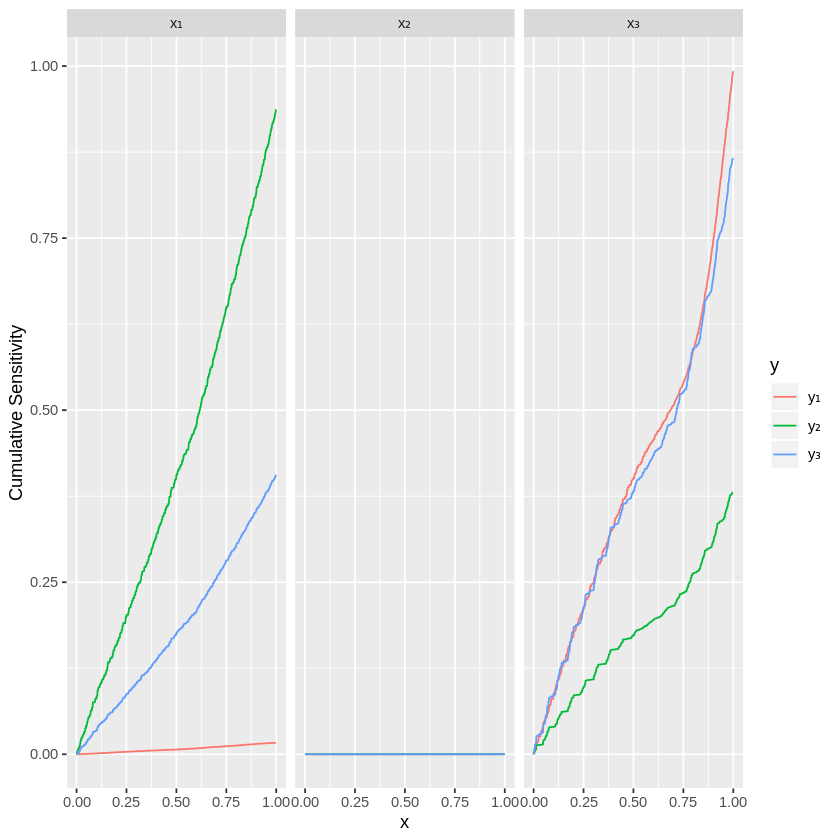

In [19]:
ggplot(
    w.local[
        Sensitivity == "Total" & Block == "a"
    ][
        order(Input, Output, Block, x)
    ][
        , .(x, `Cumulative Sensitivity` = cumsum(Index)), by = .(Input, Output, Block)
    ]
,   aes(x = x, y = `Cumulative Sensitivity`, color = Output)
) +
geom_line() +
facet_grid(. ~ Input) +
#facet_wrap(. ~ Input, scales = "free_y") +
labs(color = "y")

In [20]:
ggsave("figures/toy-tx.png", width = 6.5, height = 3.0, units = "in")

#### Sensitivity density.

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_smooth).”

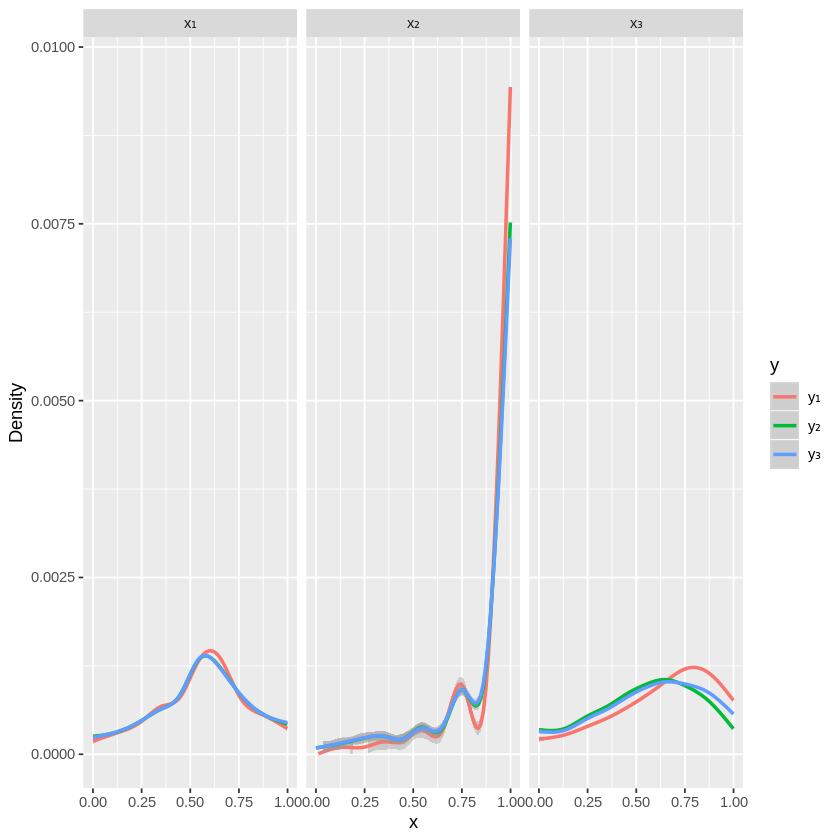

In [21]:
w.density <- ssa.sensitivity.density(w.local)
w.density1 <- w.density[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, Output, x)
    ]
w.density1 <- w.density1[, .(x, Density = Density / sum(Density)), by=.(Input, Output)]
#w.density1[, sum(Density), by=.(Input, Output)]
ggplot(
    w.density1[
        order(Input, Output, x)
    ]
,   aes(x = x, y = Density, color=Output)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_grid(. ~ Input) +
labs(color = "y") #+
#theme(axis.title.y=element_blank(),
#        axis.text.y=element_blank(),
#        axis.ticks.y=element_blank())

In [22]:
ggsave("figures/toy-tau.png", width = 6.5, height = 3.0, units = "in")

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_smooth).”

#### Metric for sampling.

In [23]:
reflines <- data.table(
    Input = c("x₁", "x₂", "x₃"),
    Reference = c(0.593385165324435, 0.948547213338315, 0.102978735696524)
)
reflines

Input,Reference
<chr>,<dbl>
x₁,0.5933852
x₂,0.9485472
x₃,0.1029787


Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”

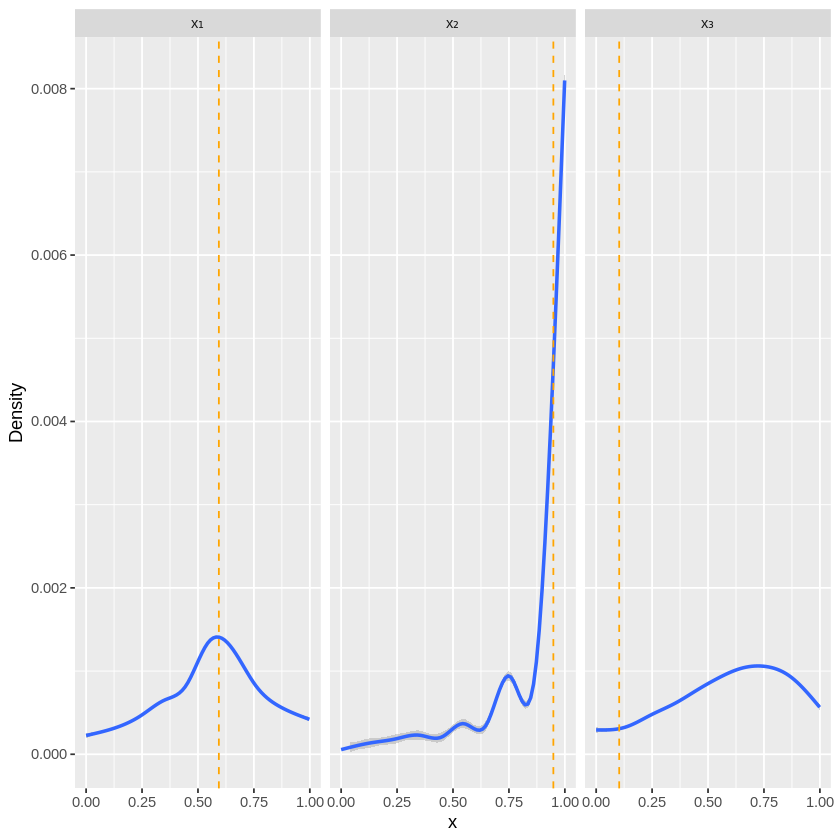

In [24]:
w.metric <- ssa.metric(w.density)
ggplot(
    w.metric[, .(x, Density = Density / sum(Density)), by=.(Input)]
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_grid(. ~ Input) +
geom_vline(data = reflines, aes(xintercept = Reference) , linetype = "dashed", color = "orange")

In [25]:
ggsave("figures/toy-taubar.png", width = 6.5, height = 3.0, units = "in")

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”

### Small sequential batches.

#### Batch size.

In [26]:
dn <- 10

#### Initialize.

In [27]:
z <- ssa.initialize(dn, f, (0:20) / 2)

In [28]:
z <- ssa.evaluate(z)

#### Initial sensitivity density.

In [29]:
z.local <- ssa.sensitivity.local(z, alpha = 2)
z.density <- ssa.sensitivity.density(z.local)

### Iterate.

In [30]:
for (p in 1:99) {
    z.local <- ssa.sensitivity.local(z, alpha = 2)
    z.density <- ssa.sensitivity.density(z.local)
    z.metric <- ssa.metric(z.density)
    z <- ssa.expand(z, z.metric, dn, beta = 0.5)
    z <- ssa.evaluate(z)
}

#### Histograms.

Warning message:
“Ignoring unknown parameters: method, formula”

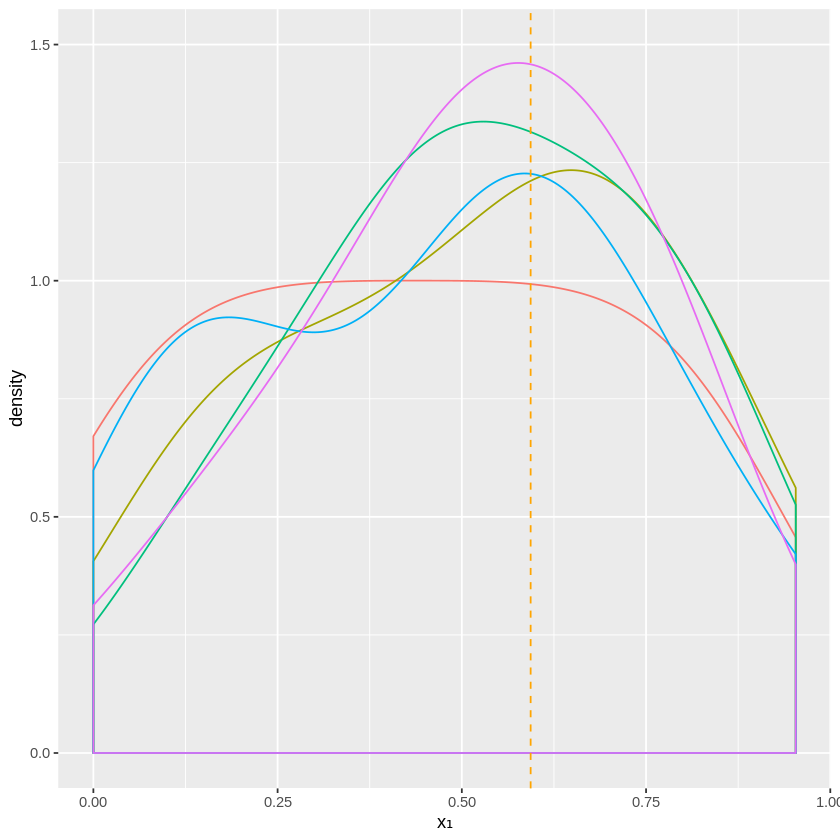

In [31]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )[Batch <= 5, .(x_1, x_2, x_3, Batch = factor(Batch))]
,   aes(x = x_1, color = Batch)
) + geom_density(method = "gam", bw = 0.15, formula = y ~ s(x, bs = "cs")) +
ylim(0, 1.5) +
geom_vline(xintercept = reflines[Input == "x₁", Reference], linetype = "dashed", color = "orange") +
theme(legend.position = "none") +
labs(x = "x₁")

In [32]:
ggsave("figures/toy-density1.png", width = 2.15, height = 2.15, units = "in")

Warning message:
“Ignoring unknown parameters: method, formula”

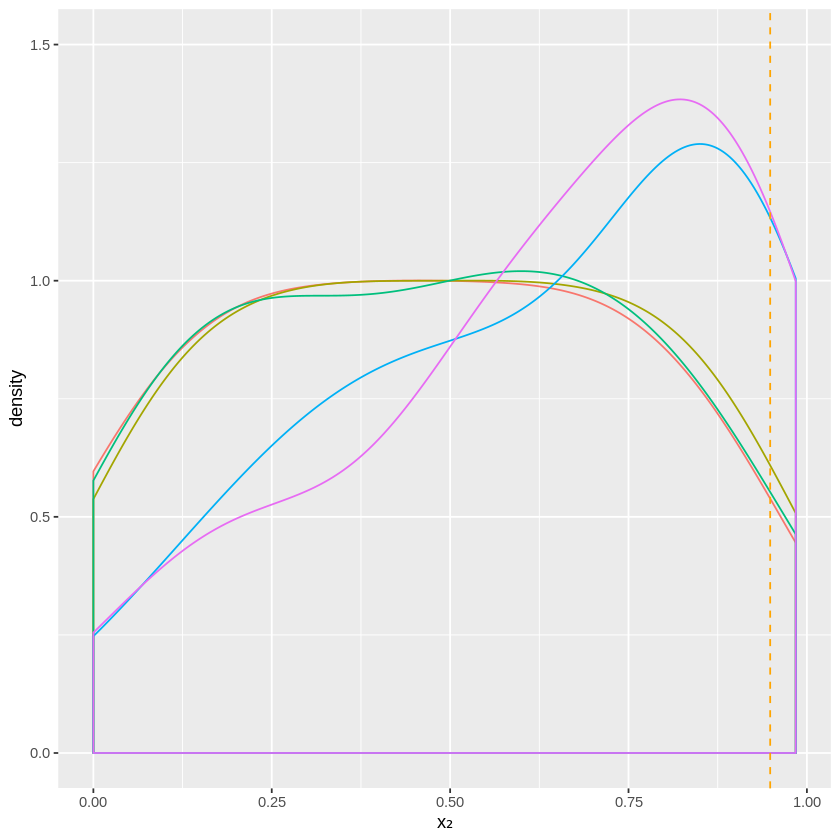

In [33]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )[Batch <= 5, .(x_1, x_2, x_3, Batch = factor(Batch))]
,   aes(x = x_2, color = Batch)
) + geom_density(method = "gam", bw = 0.15, formula = y ~ s(x, bs = "cs")) +
ylim(0, 1.5) +
geom_vline(xintercept = reflines[Input == "x₂", Reference], linetype = "dashed", color = "orange") +
theme(legend.position = "none") +
labs(x = "x₂")

In [34]:
ggsave("figures/toy-density2.png", width = 2.15, height = 2.15, units = "in")

Warning message:
“Ignoring unknown parameters: method, formula”

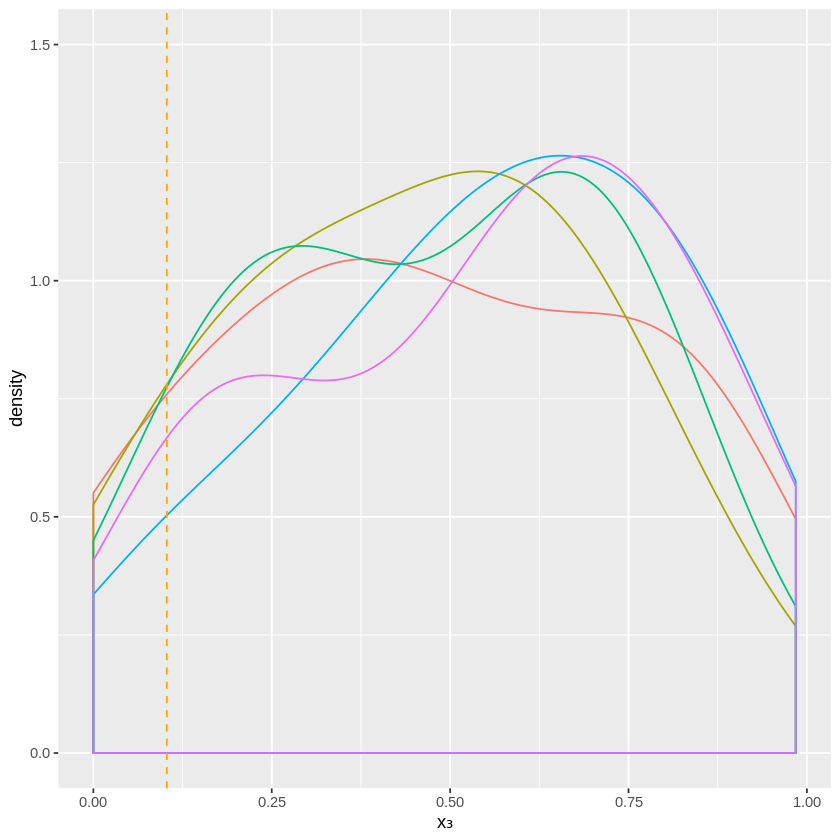

In [35]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )[Batch <= 5, .(x_1, x_2, x_3, Batch = factor(Batch))]
,   aes(x = x_3, color = Batch)
) + geom_density(method = "gam", bw = 0.15, formula = y ~ s(x, bs = "cs")) +
ylim(0, 1.5) +
geom_vline(xintercept = reflines[Input == "x₃", Reference], linetype = "dashed", color = "orange") +
theme(legend.position = "none") +
labs(x = "x₃")

In [36]:
ggsave("figures/toy-density3.png", width = 2.15, height = 2.15, units = "in")

Warning message:
“Ignoring unknown parameters: method, formula”

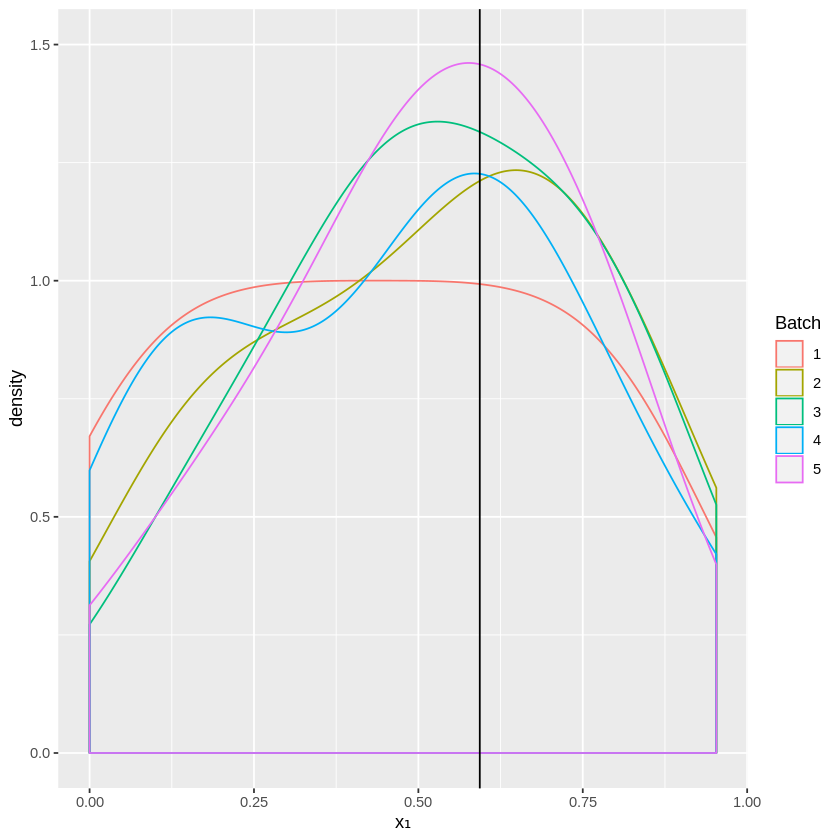

In [37]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )[Batch <= 5, .(x_1, x_2, x_3, Batch = factor(Batch))]
,   aes(x = x_1, color = Batch)
) + geom_density(method = "gam", bw = 0.15, formula = y ~ s(x, bs = "cs")) +
ylim(0, 1.5) +
geom_vline(xintercept = reflines[Input == "x₁", Reference]) +
labs(x = "x₁")

In [38]:
ggsave("figures/toy-density.png", width = 2.15, height = 2.15, units = "in")

#### $x_1$ vs $x_2$.

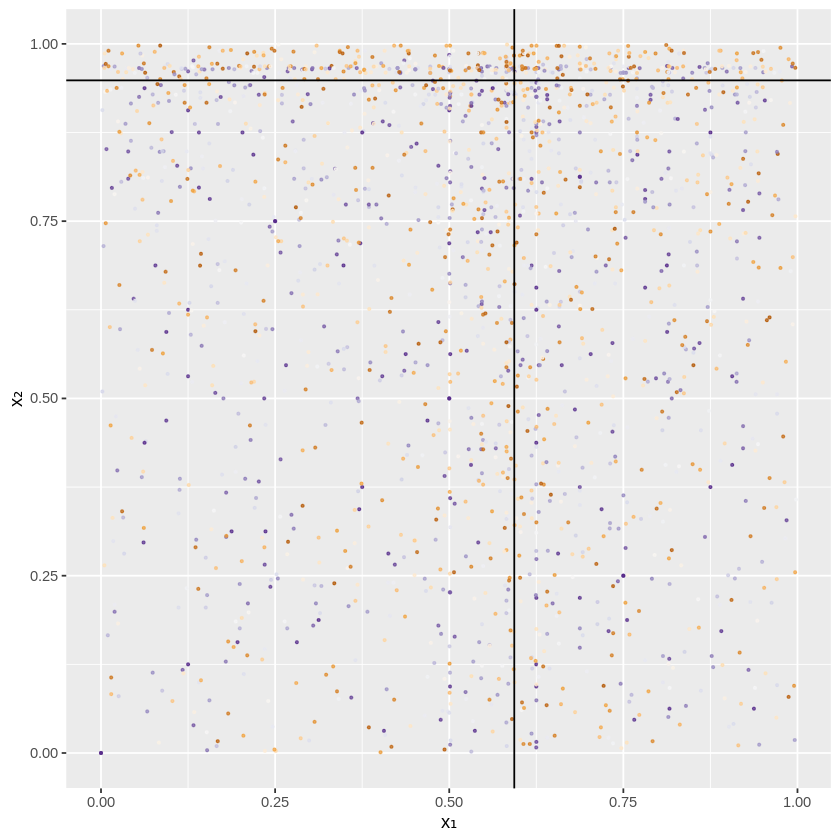

In [39]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_1, y = x_2, color = Batch)
) + geom_point(size = 0.5, alpha = 0.75) +
scale_color_distiller(palette = "PuOr") +
theme(legend.position = "none") +
geom_vline(xintercept = reflines[Input == "x₁", Reference]) +
geom_hline(yintercept = reflines[Input == "x₂", Reference]) +
labs(x = "x₁", y = "x₂")

In [40]:
ggsave("figures/toy-sample12.png", width = 2.15, height = 2.15, units = "in")

#### $x_2$ vs $x_3$.

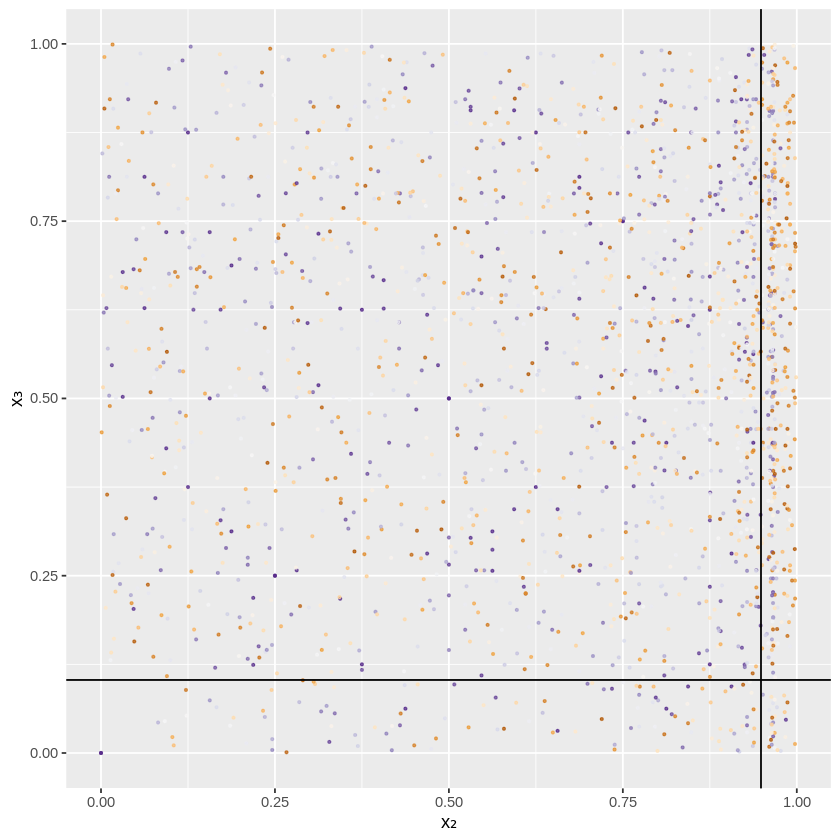

In [41]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_2, y = x_3, color = Batch)
) + geom_point(size = 0.5, alpha = 0.75) +
scale_color_distiller(palette = "PuOr") +
theme(legend.position = "none") +
geom_vline(xintercept = reflines[Input == "x₂", Reference]) +
geom_hline(yintercept = reflines[Input == "x₃", Reference]) +
labs(x = "x₂", y = "x₃")

In [42]:
ggsave("figures/toy-sample23.png", width = 2.15, height = 2.15, units = "in")

#### $x_3$ vs $x_1$.

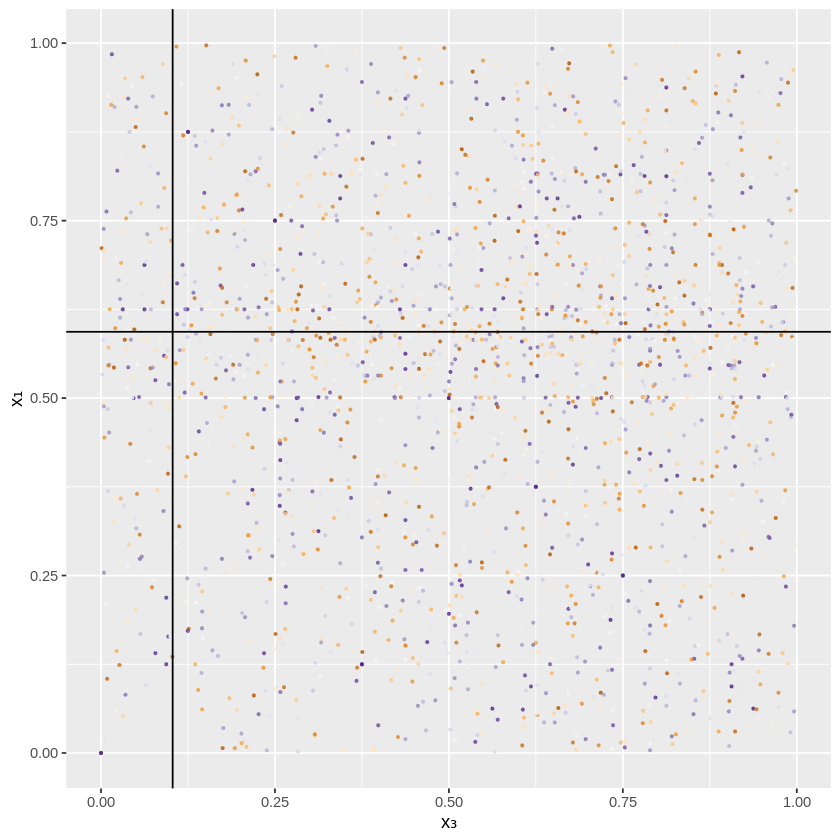

In [43]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_3, y = x_1, color = Batch)
) + geom_point(size = 0.5, alpha = 0.75) +
scale_color_distiller(palette = "PuOr") +
theme(legend.position = "none") +
geom_vline(xintercept = reflines[Input == "x₃", Reference]) +
geom_hline(yintercept = reflines[Input == "x₁", Reference]) +
labs(x = "x₃", y ="x₁")

In [44]:
ggsave("figures/toy-sample31.png", width = 2.15, height = 2.15, units = "in")

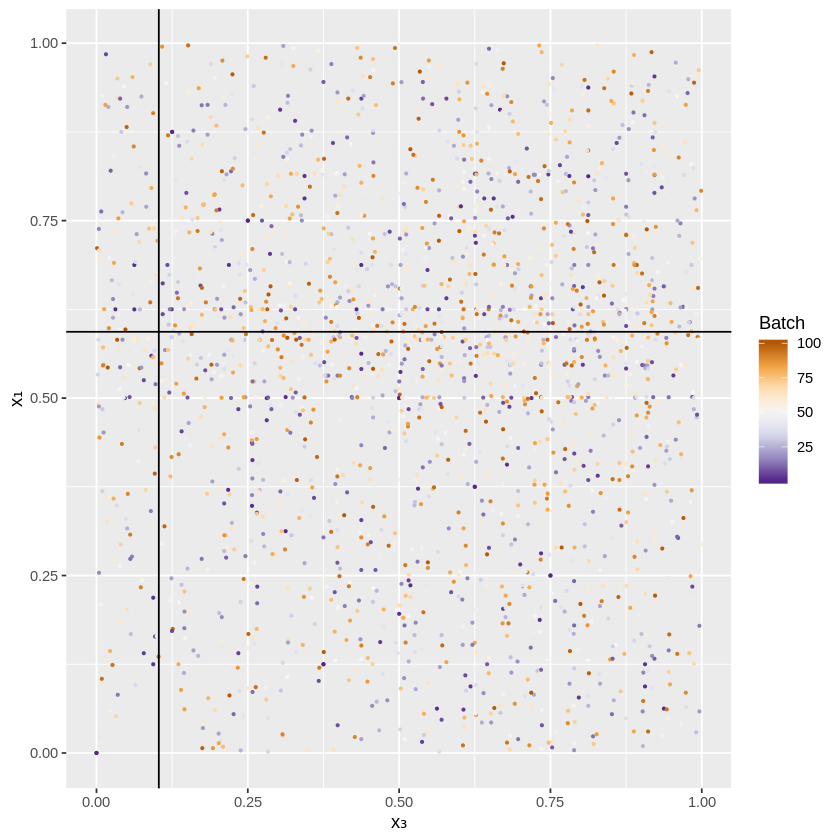

In [45]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_3, y = x_1, color = Batch)
) + geom_point(size = 0.5) +
scale_color_distiller(palette = "PuOr") +
geom_vline(xintercept = reflines[Input == "x₃", Reference]) +
geom_hline(yintercept = reflines[Input == "x₁", Reference]) +
labs(x = "x₃", y ="x₁")

In [46]:
ggsave("figures/toy-sample.png", width = 2.15, height = 2.15, units = "in")

## Bioproducts Transition Dynamics.

### Read files.

In [47]:
z.design <- fread("gunzip -c data/design-si.tsv.gz")
z.design %>% dim

[1] 2500   64

In [48]:
n <- dim(z.design)[1]
k <- dim(z.design)[2] / 2

In [49]:
n

[1] 2500

In [50]:
k

[1] 32

In [51]:
z.inputs <- fread("gunzip -c data/inputs-si.tsv.gz")
z.inputs %>% dim

[1] 85000    33

In [52]:
z.outputs <- fread("cat data/outputs-si-wide.tsv.gz.part?? | gunzip -c")
z.outputs %>% dim

[1] 2720000      53

### Organize inputs and outputs.

In [53]:
yy <- z.outputs[
    Replacement == "Advantaged" & Scale == "Niche" & Time == 2050,
]
yy %>% dim

[1] 85000    53

In [54]:
xa <- z.inputs[1:2500]
xa %>% dim

[1] 2500   33

In [55]:
xb <- z.inputs[1:2500 + 2500]
xb %>% dim

[1] 2500   33

In [56]:
xy <- NULL
for (icol in 5:ncol(yy)) {
    y0 <- yy[, icol, with = FALSE][[1]]
    ya <- y0[1:n]
    yb <- y0[1:n + n]
    ybia <- matrix(y0[-(1:(2*n))], nrow = n, byrow = FALSE)
    for (i in 1:32) {
        xy <- rbind(
            xy
        ,   data.table(
                j    = 1:n
            ,   i    = rep(i, n)
            ,   l    = rep(icol - 4)
            ,   xb   = as.matrix(xa[, i + 1, with=FALSE])[,1]
            ,   xa   = as.matrix(xb[, i + 1, with=FALSE])[,1]
            ,   yb   = ya
            ,   ya   = yb
            ,   yaib = ybia[, i]
            )
        )
    }
}
xy %>% summary

       j                i               l            xb           
 Min.   :   1.0   Min.   : 1.00   Min.   : 1   Min.   :0.000e+00  
 1st Qu.: 625.8   1st Qu.: 8.75   1st Qu.:13   1st Qu.:1.000e+00  
 Median :1250.5   Median :16.50   Median :25   Median :6.000e+00  
 Mean   :1250.5   Mean   :16.50   Mean   :25   Mean   :3.121e+07  
 3rd Qu.:1875.2   3rd Qu.:24.25   3rd Qu.:37   3rd Qu.:6.092e+03  
 Max.   :2500.0   Max.   :32.00   Max.   :49   Max.   :1.321e+09  
       xa                  yb                   ya            
 Min.   :0.000e+00   Min.   :-6.433e+09   Min.   :-2.059e+10  
 1st Qu.:1.000e+00   1st Qu.: 0.000e+00   1st Qu.: 0.000e+00  
 Median :6.000e+00   Median : 0.000e+00   Median : 0.000e+00  
 Mean   :3.120e+07   Mean   : 9.967e+09   Mean   : 1.005e+10  
 3rd Qu.:6.092e+03   3rd Qu.: 1.100e+01   3rd Qu.: 1.100e+01  
 Max.   :1.320e+09   Max.   : 1.066e+13   Max.   : 1.151e+13  
      yaib           
 Min.   :-3.088e+10  
 1st Qu.: 0.000e+00  
 Median : 0.000e+00  
 M

### Cumulative total sensitivity.

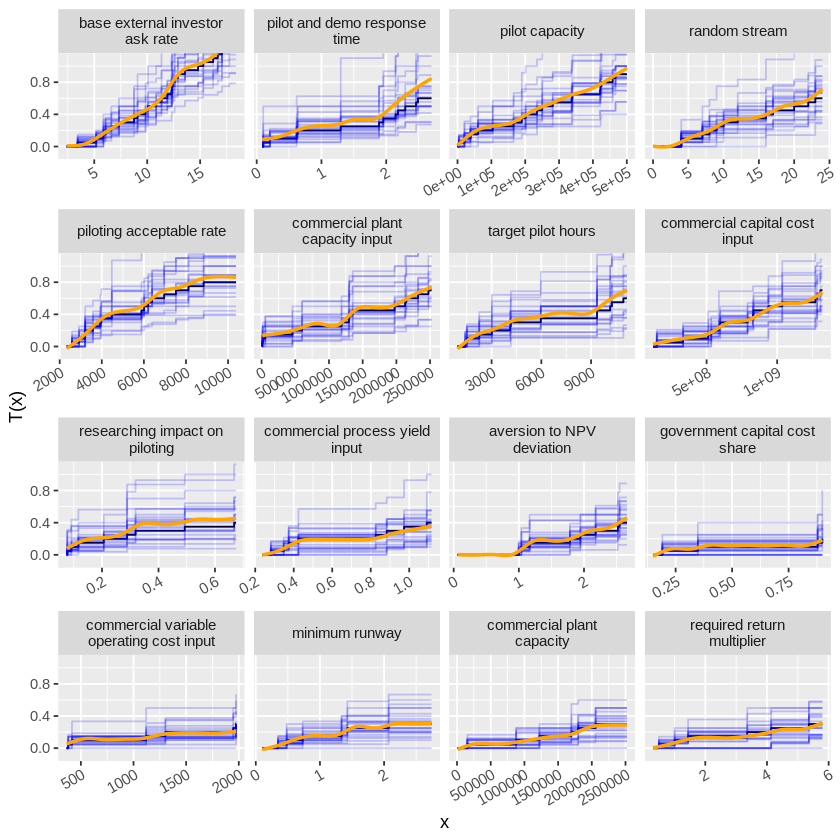

In [57]:
for (icol in 5:ncol(yy)) {

if (colnames(yy)[icol] != "demo plant construction")
    next

    
y0 <- yy[, icol, with = FALSE][[1]]
ya <- y0[1:n]
yb <- y0[1:n + n]
ybia <- matrix(y0[-(1:(2*n))], nrow = n, byrow = FALSE)
xyab <- NULL
for (i in 1:32) {
    temp <- data.table(
            Input = colnames(z.inputs)[1+i],
            xA = as.matrix(xa[, i + 1, with=FALSE]),
            xB = as.matrix(xb[, i + 1, with=FALSE]),
            yA = ya,
            yB = yb,
            yBiA = ybia[, i]
        )
    colnames(temp) <- c("Input", "xA", "xB", "yA", "yB", "yBiA")
    scale <- sqrt(((temp$yA - temp$yB) %*% (temp$yA - temp$yB))[1])
    xyab <- rbind(
        xyab, cbind(
            Sample = 0,
            temp[, .(Input, xA, xB, yA = yA / scale, yB = yB / scale, yBiA = yBiA / scale)]
        )
    )
    for (j in 1:25) {
        temp2 <- temp[sample(1:nrow(temp), nrow(temp), replace = TRUE)]
        scale <- sqrt(((temp2$yA - temp2$yB) %*% (temp2$yA - temp2$yB))[1])
        xyab <- rbind(
            xyab,
            cbind(
                Sample = j,
                temp2[, .(Input, xA, xB, yA = yA / scale, yB = yB / scale, yBiA = yBiA / scale)]
            )
        )
    }
}
xyab.sensitivity <- xyab[, .(
    S = 1 - sum((yA - yBiA)^2),
    T =     sum((yB - yBiA)^2)
), by = .(Sample, Input)]
xyab.best <- xyab.sensitivity[T >= 0.25][order(-T)][, unique(Input)][1:16]
if (length(xyab.best) == 0)
    next
xyab.temp <- rbind(xyab[, .(Input, Sample, x = xA, yB, yBiA)], xyab[, .(Input, Sample, x = xB, yB, yBiA)])[
        Input %in% xyab.best,
        .(Sample, Input=factor(Input, levels = xyab.best), x, yB = yB / sqrt(2), yBiA = yBiA / sqrt(2))
    ][
        order(Input, Sample, x)
    ][,
      .(x, T = cumsum((yB - yBiA)^2)), by = .(Input, Sample)
     ]
g <- ggplot(xyab.temp, aes(x = x, y = T)) +
    geom_line(data = xyab.temp[Sample == 0], color = "black", aes(group = Sample)) +
    geom_line(alpha = 0.2, color = "blue", aes(group = Sample)) +
    geom_smooth(color = "orange", method = "gam", formula = y ~ s(x, bs = "cs")) +
    facet_wrap(Input ~ . , scales = "free_x", labeller = label_wrap_gen()) +
    theme(axis.text.x = element_text(angle = 30, hjust=1), strip.text.x = element_text(size = 9)) +
    ylab("T(x)") +
    coord_cartesian(ylim = c(-0.1, 1.1)) #+
    #ggtitle(paste("Cumulative Total Sensitivity for", colnames(yy)[icol]))
print(g)
   
    
}

In [58]:
ggsave("figures/btd-t.png", width = 6.50, height = 6.50, units = "in")

### Sampling density.

In [59]:
st <- merge(
    xy
,   xy[i == 1, .(scale = sum(abs(ya - yb)^2)), by = .(l)][scale > 0]
,   by = "l"
)[, .(
    j, i, l
,   xa, xb
,   s = abs(yb - yaib)^2 / scale
,   t = abs(ya - yaib)^2 / scale
)][order(j, i, l)]
z.local <- melt(
    melt(
        st[, .(
            Observation = j
        ,   Input       = colnames(z.inputs )[1+i]
        ,   Output      = colnames(z.outputs)[4+l]
        ,   a           = xa
        ,   b           = xb
        ,   First       = s
        ,   Total       = t
        )]
    ,   id.vars = c("Observation", "Input", "Output", "First", "Total")
    ,   variable.name = "Block"
    ,   value.name = "x"
    )
,   id.vars = c("Observation", "Input", "Output", "Block", "x")
,   variable.name = "Sensitivity"
,   value.name = "Index"
)

In [60]:
epsilon <- 1e-5
z.density <- z.local[
    Sensitivity == "Total" # & Index > 0
,   .(
        xmin   = min(x) - epsilon / 2
    ,   xmax   = max(x) + epsilon / 2
    ,   Index  = mean(Index)
    ,   Weight = 1
    )
,   by = .(Input, Output, Observation)
][, .(
    Input
,   Output
,   xmin
,   xmax
,   Index  = Index  / (xmax - xmin + epsilon)
,   Weight = Weight / (xmax - xmin + epsilon)
)]
z.density <- rbind(
    z.density[, .(x = xmin, Index          , Weight           ), by = .(Input, Output)]
,   z.density[, .(x = xmax, Index = - Index, Weight = - Weight), by = .(Input, Output)]
)[order(Input, Output, x)][, .(x, Index = cumsum(Index), Weight = cumsum(Weight)), by = .(Input, Output)]

Warning message:
“Removed 54 rows containing missing values (geom_smooth).”

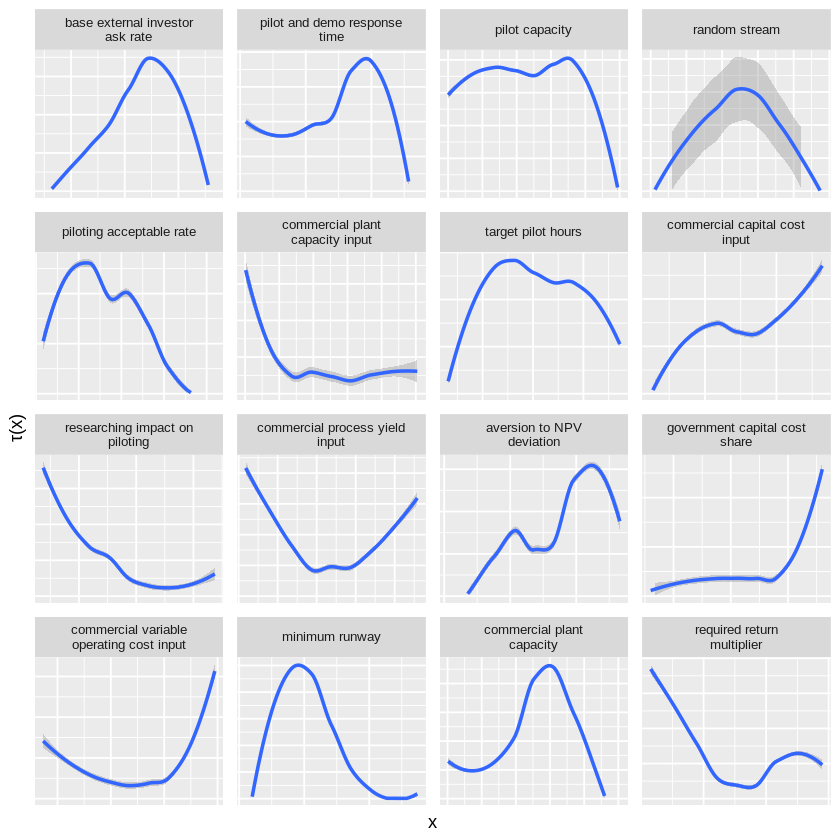

In [61]:
for (outname in z.density[, unique(Output)]) {

    if (outname != "demo plant construction")
    next

    g <- ggplot(
        z.density[Output == outname & Input %in% xyab.best
            , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input = factor(Input, levels = xyab.best), Output, x)
        ][
            order(Input, Output, x)
        ]
    ,   aes(x = x, y = Density)
    ) +
    geom_smooth(method = "loess")+#, formula = y ~ s(x, bs = "cs")) +
    scale_y_continuous(limits = c(0, NA)) +
    facet_wrap(. ~ Input, scales = "free", labeller = label_wrap_gen()) +
    #ggtitle(paste("Variance-Based Sampling Density for", outname)) +
    theme(
        strip.text.x = element_text(size = 8)
    ,   strip.text.y = element_text(size = 8)
    #,   axis.title.x =element_blank()
    ,   axis.text.x  = element_blank()
    ,   axis.ticks.x =element_blank()
    #,   axis.title.y =element_blank()
    ,   axis.text.y  =element_blank()
    ,   axis.ticks.y =element_blank()
    ) + labs(x = "x", y = "τ(x)")
    print(g)
}

In [62]:
ggsave("figures/btd-tau.png", width = 6.50, height = 6.50, units = "in")

Warning message:
“Removed 54 rows containing missing values (geom_smooth).”

### Overall sampling density.

In [63]:
z.metric <- z.density[
    , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, Output, x)
]
z.metric <- merge(
    z.metric
,   z.metric[, .(Scale = sum(Density)), by = .(Input, Output)]
)[
    Scale > 0
][
    , .(Density = Density / Scale), by = .(Input, Output, x)
][
    , .(Density = mean(Density)), by = .(Input, x)
][
    order(Input, x)
][
    , .(x, Density, Cumulative = cumsum(Density)), by = Input
]

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_smooth).”

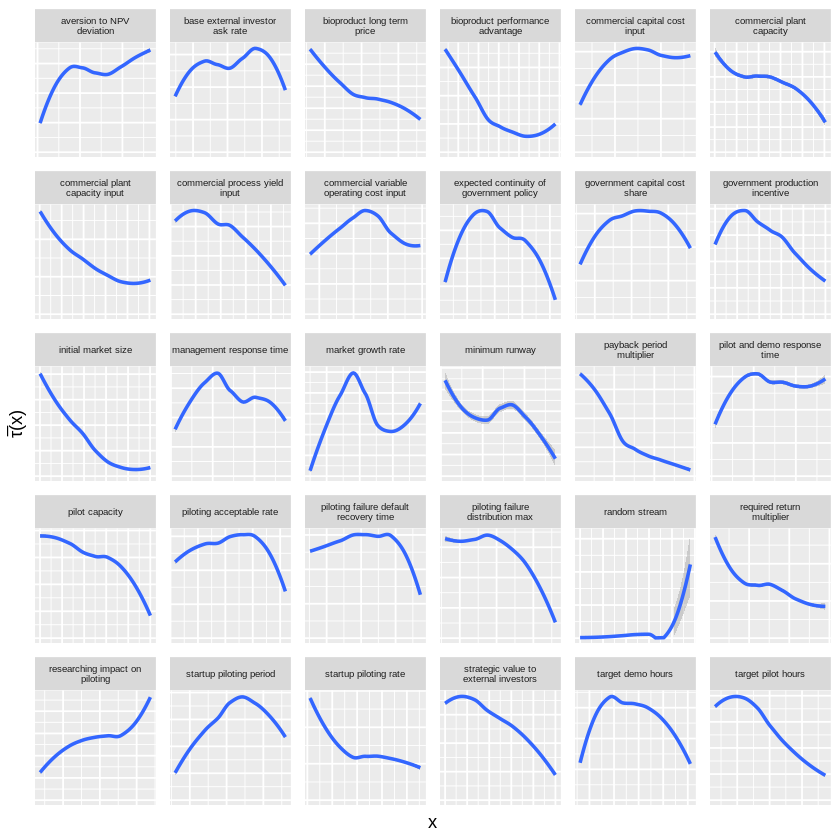

In [64]:
ggplot(
    z.metric
,   aes(x = x, y = Density)
) +
geom_smooth(method = "loess")+#gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(. ~ Input, scales = "free", labeller = label_wrap_gen()) +
#ggtitle("Variance-Based Sampling Density") +
theme(
    strip.text.x = element_text(size = 5.75)
,   strip.text.y = element_text(size = 5.75)
#,   axis.title.x =element_blank()
,   axis.text.x  =element_blank()
,   axis.ticks.x =element_blank()
#,   axis.title.y =element_blank()
,   axis.text.y  =element_blank()
,   axis.ticks.y =element_blank()
) +
labs(x = "x", y = "τ̅(x)")

In [65]:
ggsave("figures/btd-taubar.png", width = 6.50, height = 6.50, units = "in")

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_smooth).”